In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score

In [2]:
#Dataset - https://public.enigma.com/datasets/nfirs-general-incident-information-2014/f0dfa766-c897-4f00-8ea6-753b9b9177f5
input_df = pd.read_csv('general_incident_2014.csv')

In [3]:
df = input_df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2116746 entries, 0 to 2116745
Data columns (total 56 columns):
state                   object
state_definition        object
fdid                    object
inc_date                object
inc_date_unparsed       int64
inc_no                  object
exp_no                  int64
version                 float64
dept_sta                object
inc_type                int64
inc_type_definition     object
add_wild                object
aid                     object
aid_definition          object
alarm                   object
alarm_unparsed          int64
arrival                 object
arrival_unparsed        int64
inc_cont                object
inc_cont_unparsed       float64
lu_clear                object
lu_clear_unparsed       float64
shift                   object
alarms                  object
district                object
act_tak1                object
act_tak1_definition     object
act_tak2                object
act_tak2_definition  

# Data Cleaning

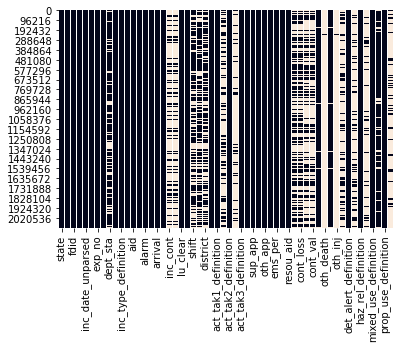

In [4]:
sns.heatmap(df.isnull(), cbar=False) #Missing Values in data

In [5]:
df.isnull().sum() #Missing values in data

state                       329
state_definition              0
fdid                          0
inc_date                      0
inc_date_unparsed             0
inc_no                        0
exp_no                        0
version                       0
dept_sta                 557513
inc_type                      0
inc_type_definition           0
add_wild                      0
aid                           0
aid_definition                0
alarm                         0
alarm_unparsed                0
arrival                       0
arrival_unparsed              0
inc_cont                1612496
inc_cont_unparsed       1612496
lu_clear                    114
lu_clear_unparsed           114
shift                    864533
alarms                   755312
district                 893632
act_tak1                      3
act_tak1_definition           1
act_tak2                1437009
act_tak2_definition        2550
act_tak3                1858837
act_tak3_definition         570
app_mod 

In [6]:
#dropping fields with significantly high missing values (> half the entries)
df.drop(['inc_cont_unparsed', 'prop_loss', 'cont_loss', 'prop_val', 
                 'cont_val', 'oth_death', 'oth_inj', 'version', 'ems_app'], axis = 1, inplace = True)

#dropping rows for fields with very few missing values (<10)
df = df[pd.notnull(df['act_tak1'])]
df = df[pd.notnull(df['act_tak1_definition'])]
df = df[pd.notnull(df['lu_clear'])]
#df = df[final_input_data['act_tak1'] != 'UU']

#converting categorical fields into numeric
df['add_wild']=df['add_wild'].apply(lambda x : 1 if x == 'Y' else 0)
df['aid']=df['aid'].apply(lambda x : int(0) if x == 'N' else int(x))
df['app_mod']=df['app_mod'].apply(lambda x : int(1) if x == 'Y' else int(0))
df['resou_aid']=df['resou_aid'].apply(lambda x : int(1) if x == 'Y' else int(0))

#replacing missing values
df['det_alert'].fillna(0,inplace=True) #with 0
df['ff_death'].fillna((df['ff_death'].mean()), inplace=True) #with mean
df['ff_inj'].fillna((df['ff_inj'].mean()), inplace=True)
df['lu_clear_unparsed'].fillna((df['lu_clear_unparsed'].mean()), inplace=True)

#replacing undefined values with 0
df['det_alert']=df['det_alert'].apply(lambda x : int(0) if x == 'U' else int(x))

#defining binary target variable
df['ems_per'] = np.where(df['ems_per'] > 0.5, 1, 0) 
df_viz = df[['inc_no','state_definition','act_tak1_definition','inc_type_definition','prop_use_definition']]#for visualization
df = df.select_dtypes(['float64', 'int64','int32'])

In [8]:
df_viz.isnull().sum()

inc_no                 0
state_definition       0
act_tak1_definition    0
inc_type_definition    0
prop_use_definition    0
dtype: int64

In [31]:
df.isnull().sum()

inc_date_unparsed    0
exp_no               0
inc_type             0
add_wild             0
aid                  0
alarm_unparsed       0
arrival_unparsed     0
lu_clear_unparsed    0
app_mod              0
sup_app              0
oth_app              0
sup_per              0
ems_per              0
oth_per              0
resou_aid            0
ff_death             0
ff_inj               0
det_alert            0
dtype: int64

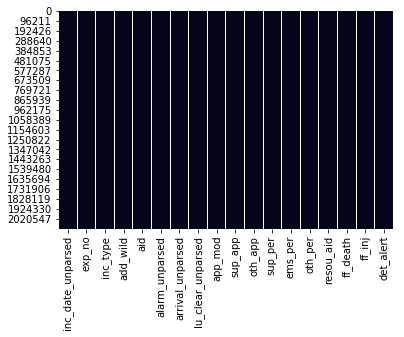

In [9]:
sns.heatmap(df.isnull(), cbar=False) #no missing values after data cleaning

In [10]:
df.describe()

,inc_date_unparsed,exp_no,inc_type,add_wild,aid,alarm_unparsed,arrival_unparsed,lu_clear_unparsed,app_mod,sup_app,oth_app,sup_per,ems_per,oth_per,resou_aid,ff_death,ff_inj,det_alert
count,2.116628e+06,2.116628e+06,2.116628e+06,2.116628e+06,2.116628e+06,2.116628e+06,2.116628e+06,2.116628e+06,2.116628e+06,2.116628e+06,2.116628e+06,2.116628e+06,2.116628e+06,2.116628e+06,2.116628e+06,2.116628e+06,2.116628e+06,2.116628e+06
mean,6.414748e+06,2.657718e-02,2.859257e+02,5.593803e-04,5.417329e-01,6.414748e+10,6.414925e+10,6.414802e+10,5.609550e-01,3.371692e+00,1.232613e+00,4.792251e+00,6.583916e-02,1.130826e+00,9.439543e-03,1.004718e-05,4.152357e-03,1.373699e-01
std,3.425535e+06,1.553472e+00,1.696737e+02,2.364461e-02,1.187407e+00,3.425535e+10,3.425523e+10,3.425436e+10,4.962707e-01,8.115283e+01,6.101363e+01,1.303894e+01,2.480008e-01,8.362184e+00,9.669768e-02,3.826989e-03,1.057915e-01,4.545535e-01
min,1.012014e+06,0.000000e+00,1.000000e+02,0.000000e+00,0.000000e+00,1.012014e+10,1.012014e+10,1.012014e+10,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.262014e+06,0.000000e+00,1.230000e+02,0.000000e+00,0.000000e+00,3.262014e+10,3.262014e+10,3.262014e+10,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.192014e+06,0.000000e+00,1.540000e+02,0.000000e+00,0.000000e+00,6.192014e+10,6.192014e+10,6.192014e+10,1.000000e+00,1.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,9.222014e+06,0.000000e+00,4.420000e+02,0.000000e+00,0.000000e+00,9.222014e+10,9.222014e+10,9.222014e+10,1.000000e+00,3.000000e+00,1.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.231201e+07,2.430000e+02,6.320000e+02,1.000000e+00,5.000000e+00,1.231201e+11,1.231201e+11,1.231201e+11,1.000000e+00,9.321000e+03,9.360000e+03,9.962000e+03,1.000000e+00,5.500000e+03,1.000000e+00,3.000000e+00,3.800000e+01,2.000000e+00


# Which state has the most number of incidents?

In [11]:
statewise_inc_count = df_viz.groupby(['state_definition']).size()
statewise_inc_count = pd.DataFrame({'state':statewise_inc_count.index, 'incident_count':statewise_inc_count.values})

In [12]:
writer = pd.ExcelWriter('statewise_inc_count.xlsx')
statewise_inc_count.to_excel(writer,'Sheet1')
writer.save()

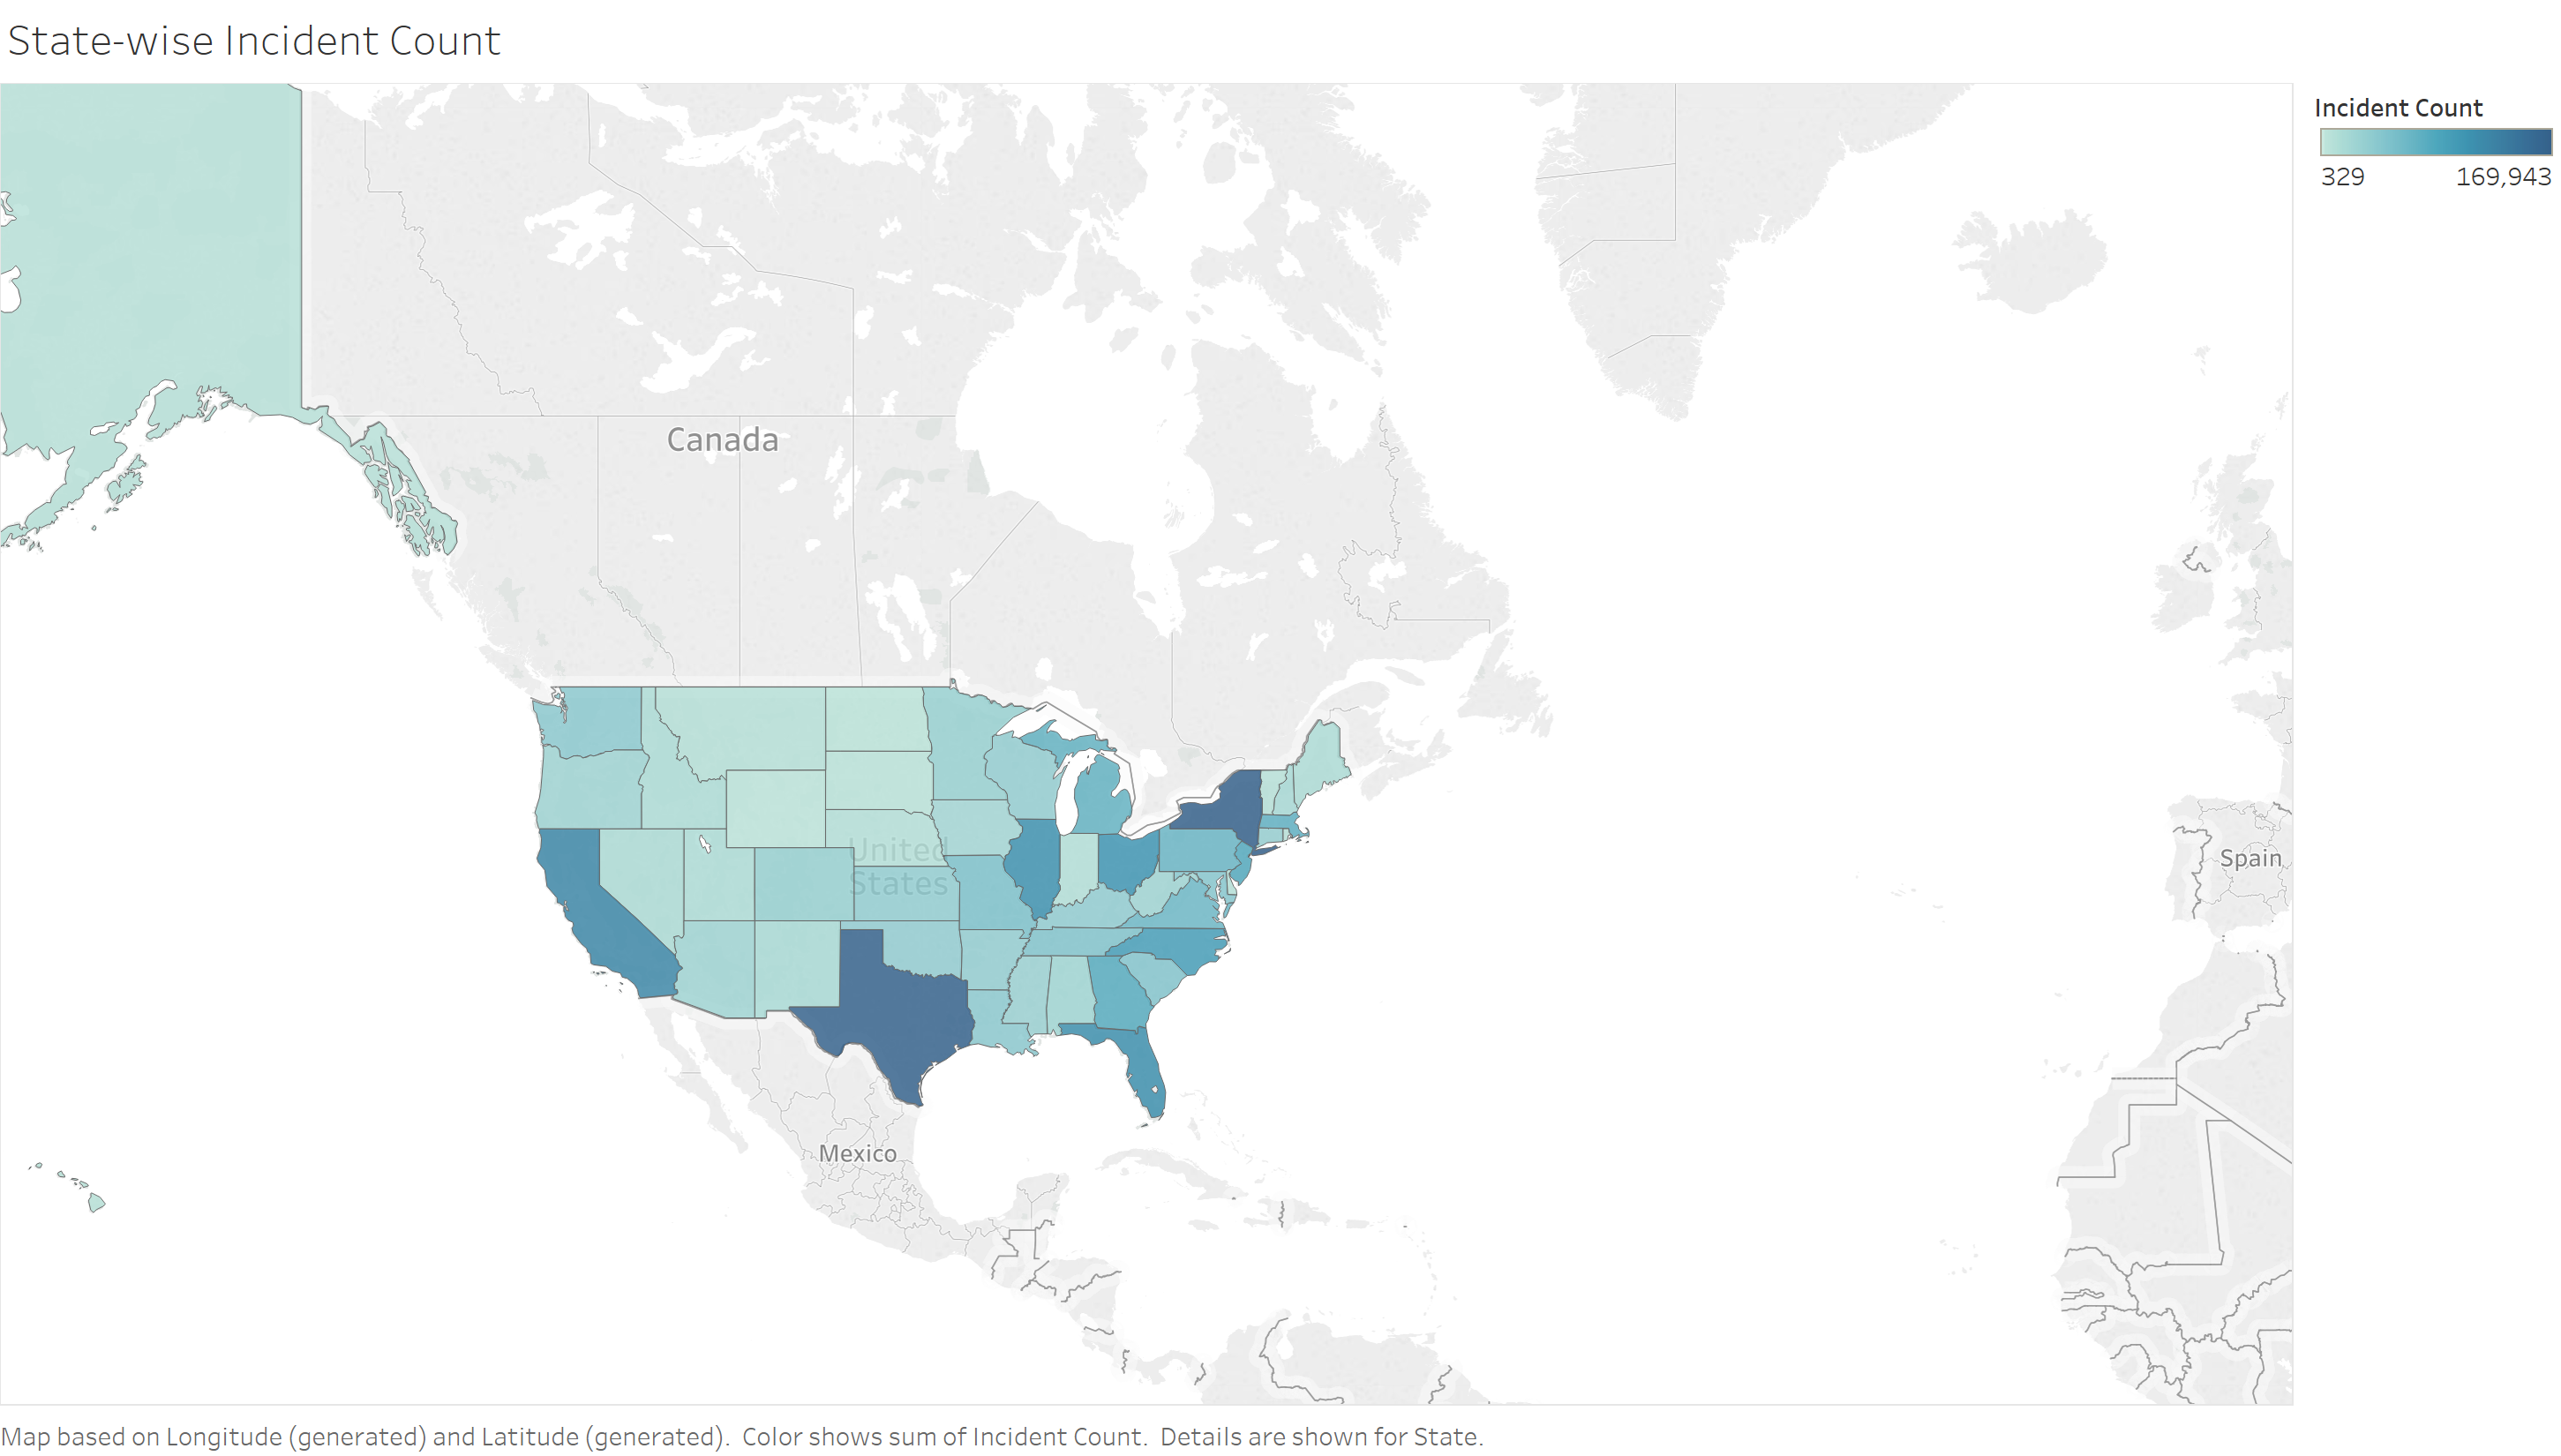

In [13]:
from IPython.display import Image
Image("Tableau_images/statewise_inc_count.png")

# Actionwise Incident Count

In [14]:
actionwise_inc_count = df_viz.groupby(['act_tak1_definition']).size()
actionwise_inc_count = pd.DataFrame({'action_type':actionwise_inc_count.index, 'incident_count':actionwise_inc_count.values}).sort_values(by='incident_count', ascending = False)

In [15]:
writer = pd.ExcelWriter('actionwise_inc_count.xlsx')
actionwise_inc_count.to_excel(writer,'Sheet1')
writer.save()

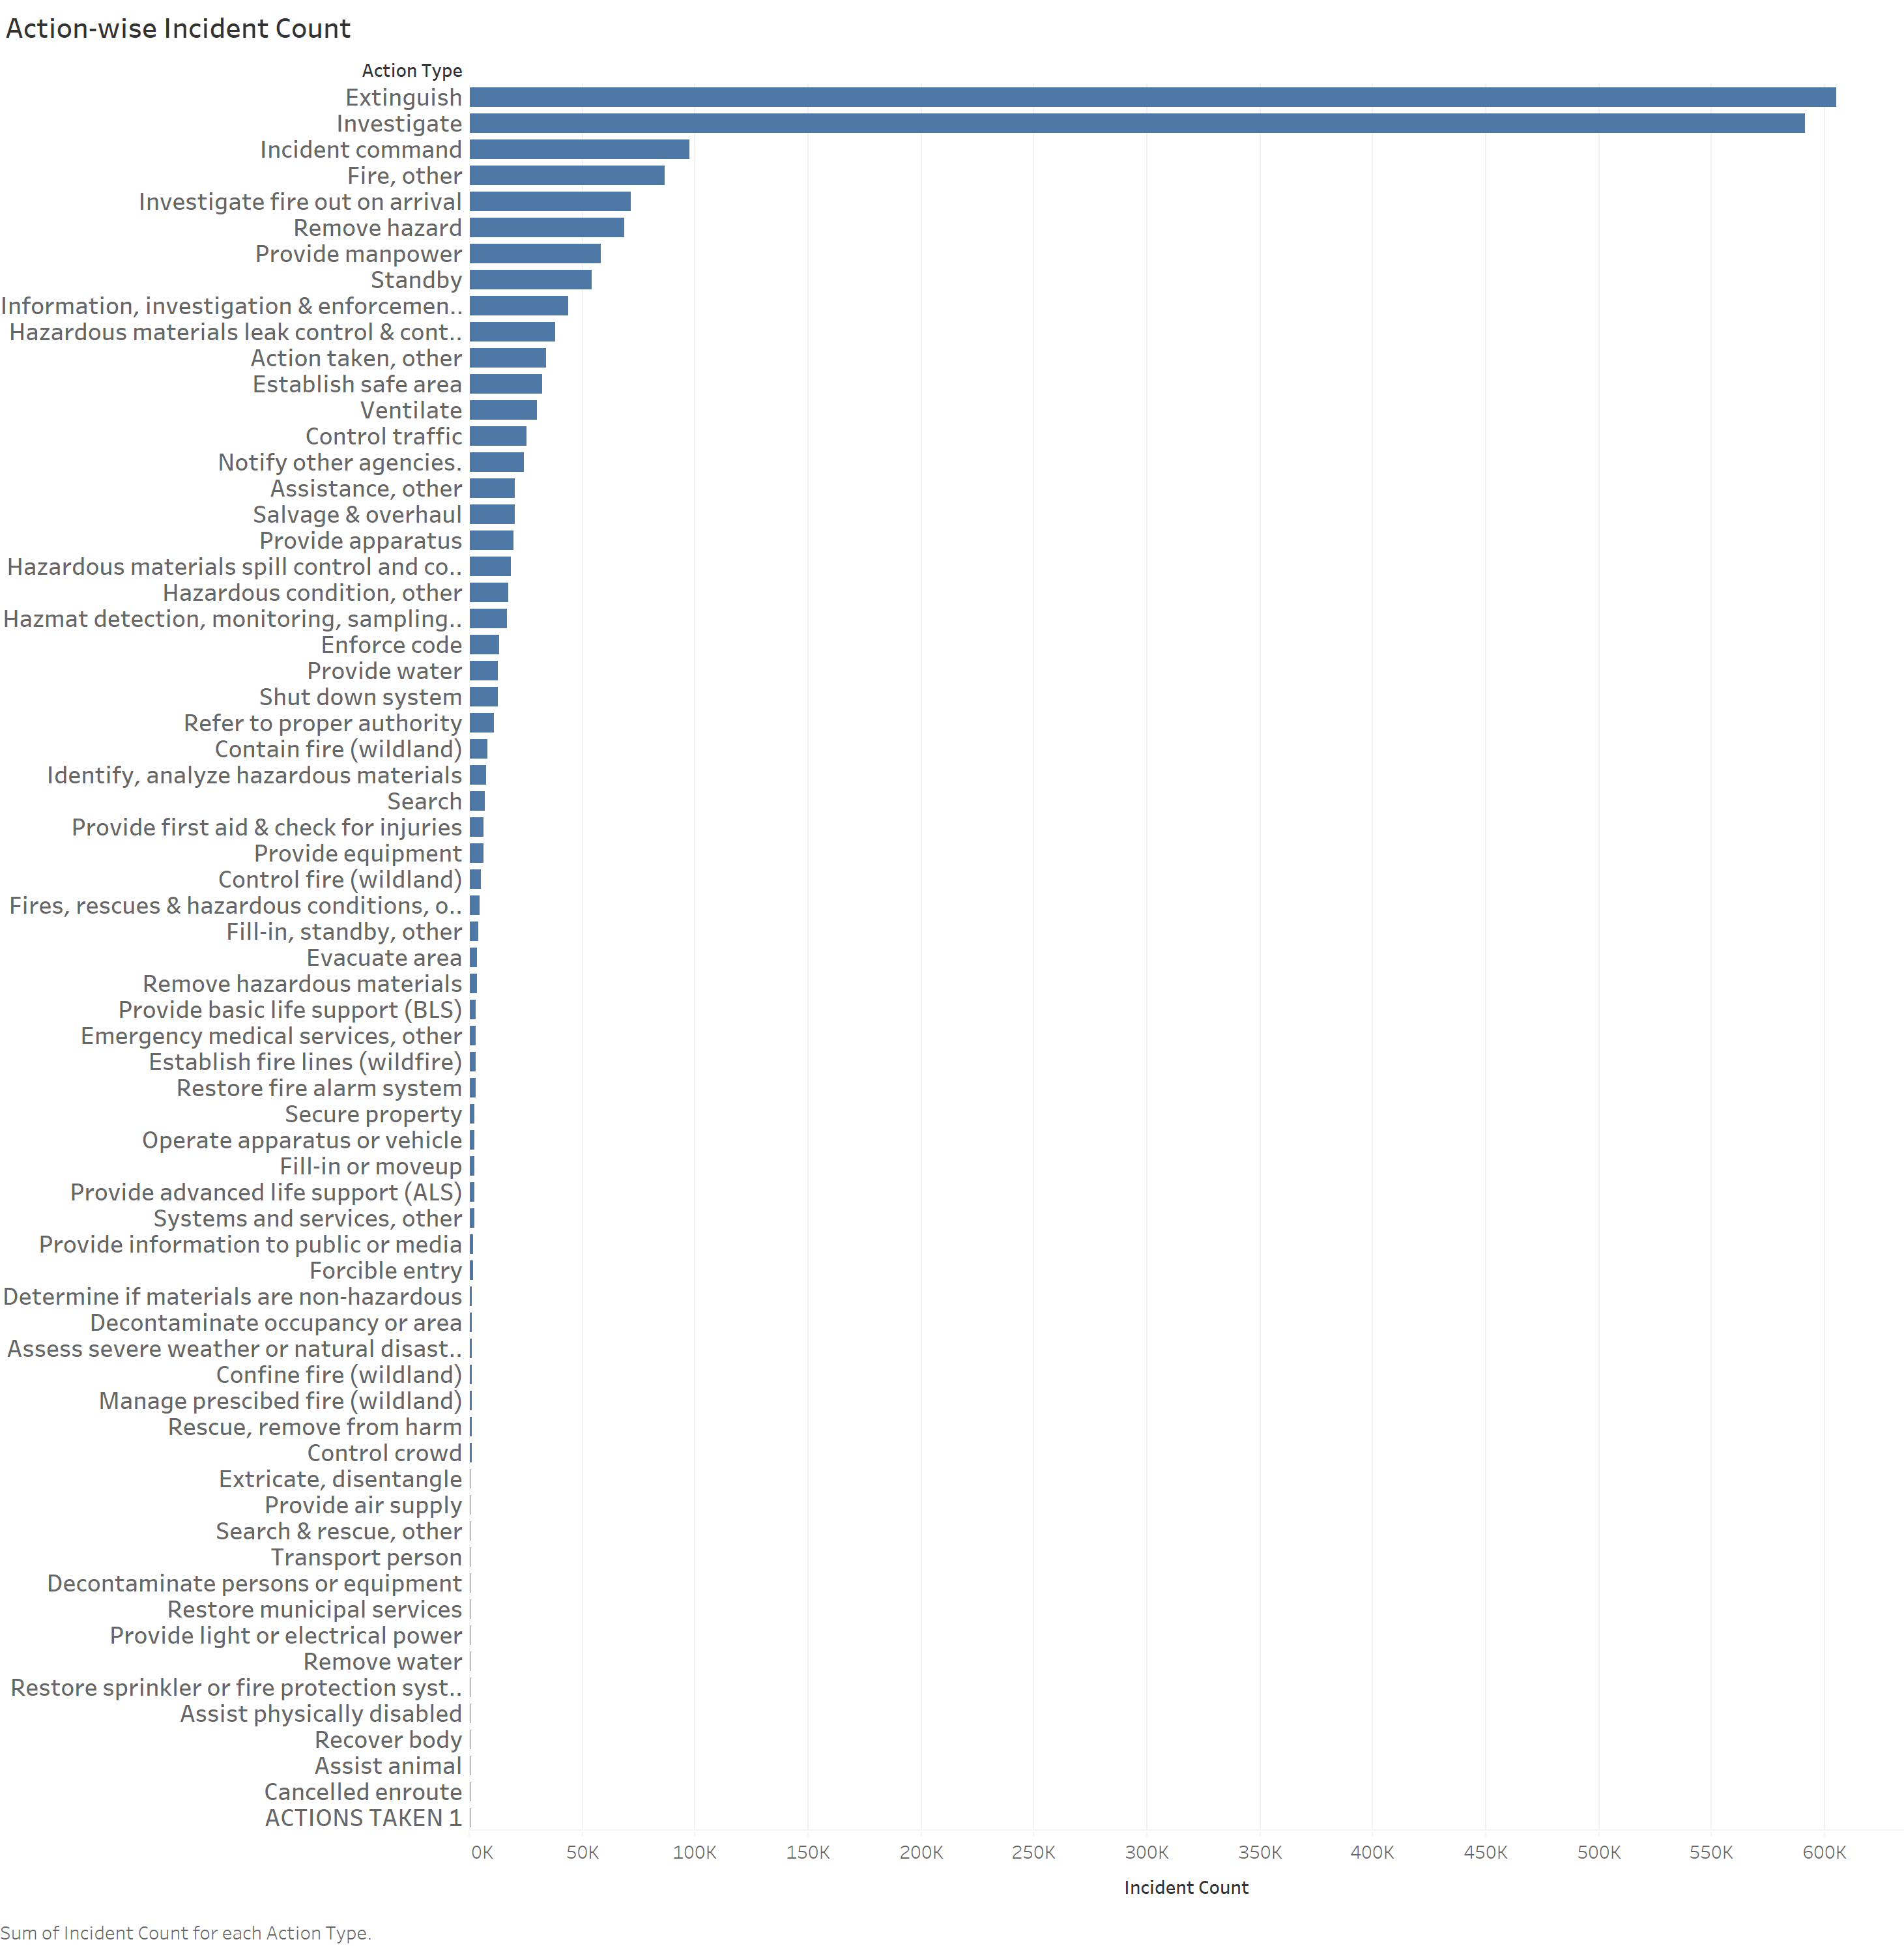

In [16]:
Image("Tableau_images/actionwise_inc_count.png")

# Incident typewise occurrence count

In [17]:
typewise_inc_count = df_viz.groupby(['inc_type_definition']).size()
typewise_inc_count = pd.DataFrame({'type':typewise_inc_count.index, 'incident_count':typewise_inc_count.values}).sort_values(by='incident_count', ascending = False)

In [18]:
writer = pd.ExcelWriter('typewise_inc_count.xlsx')
typewise_inc_count.to_excel(writer,'Sheet1')
writer.save()

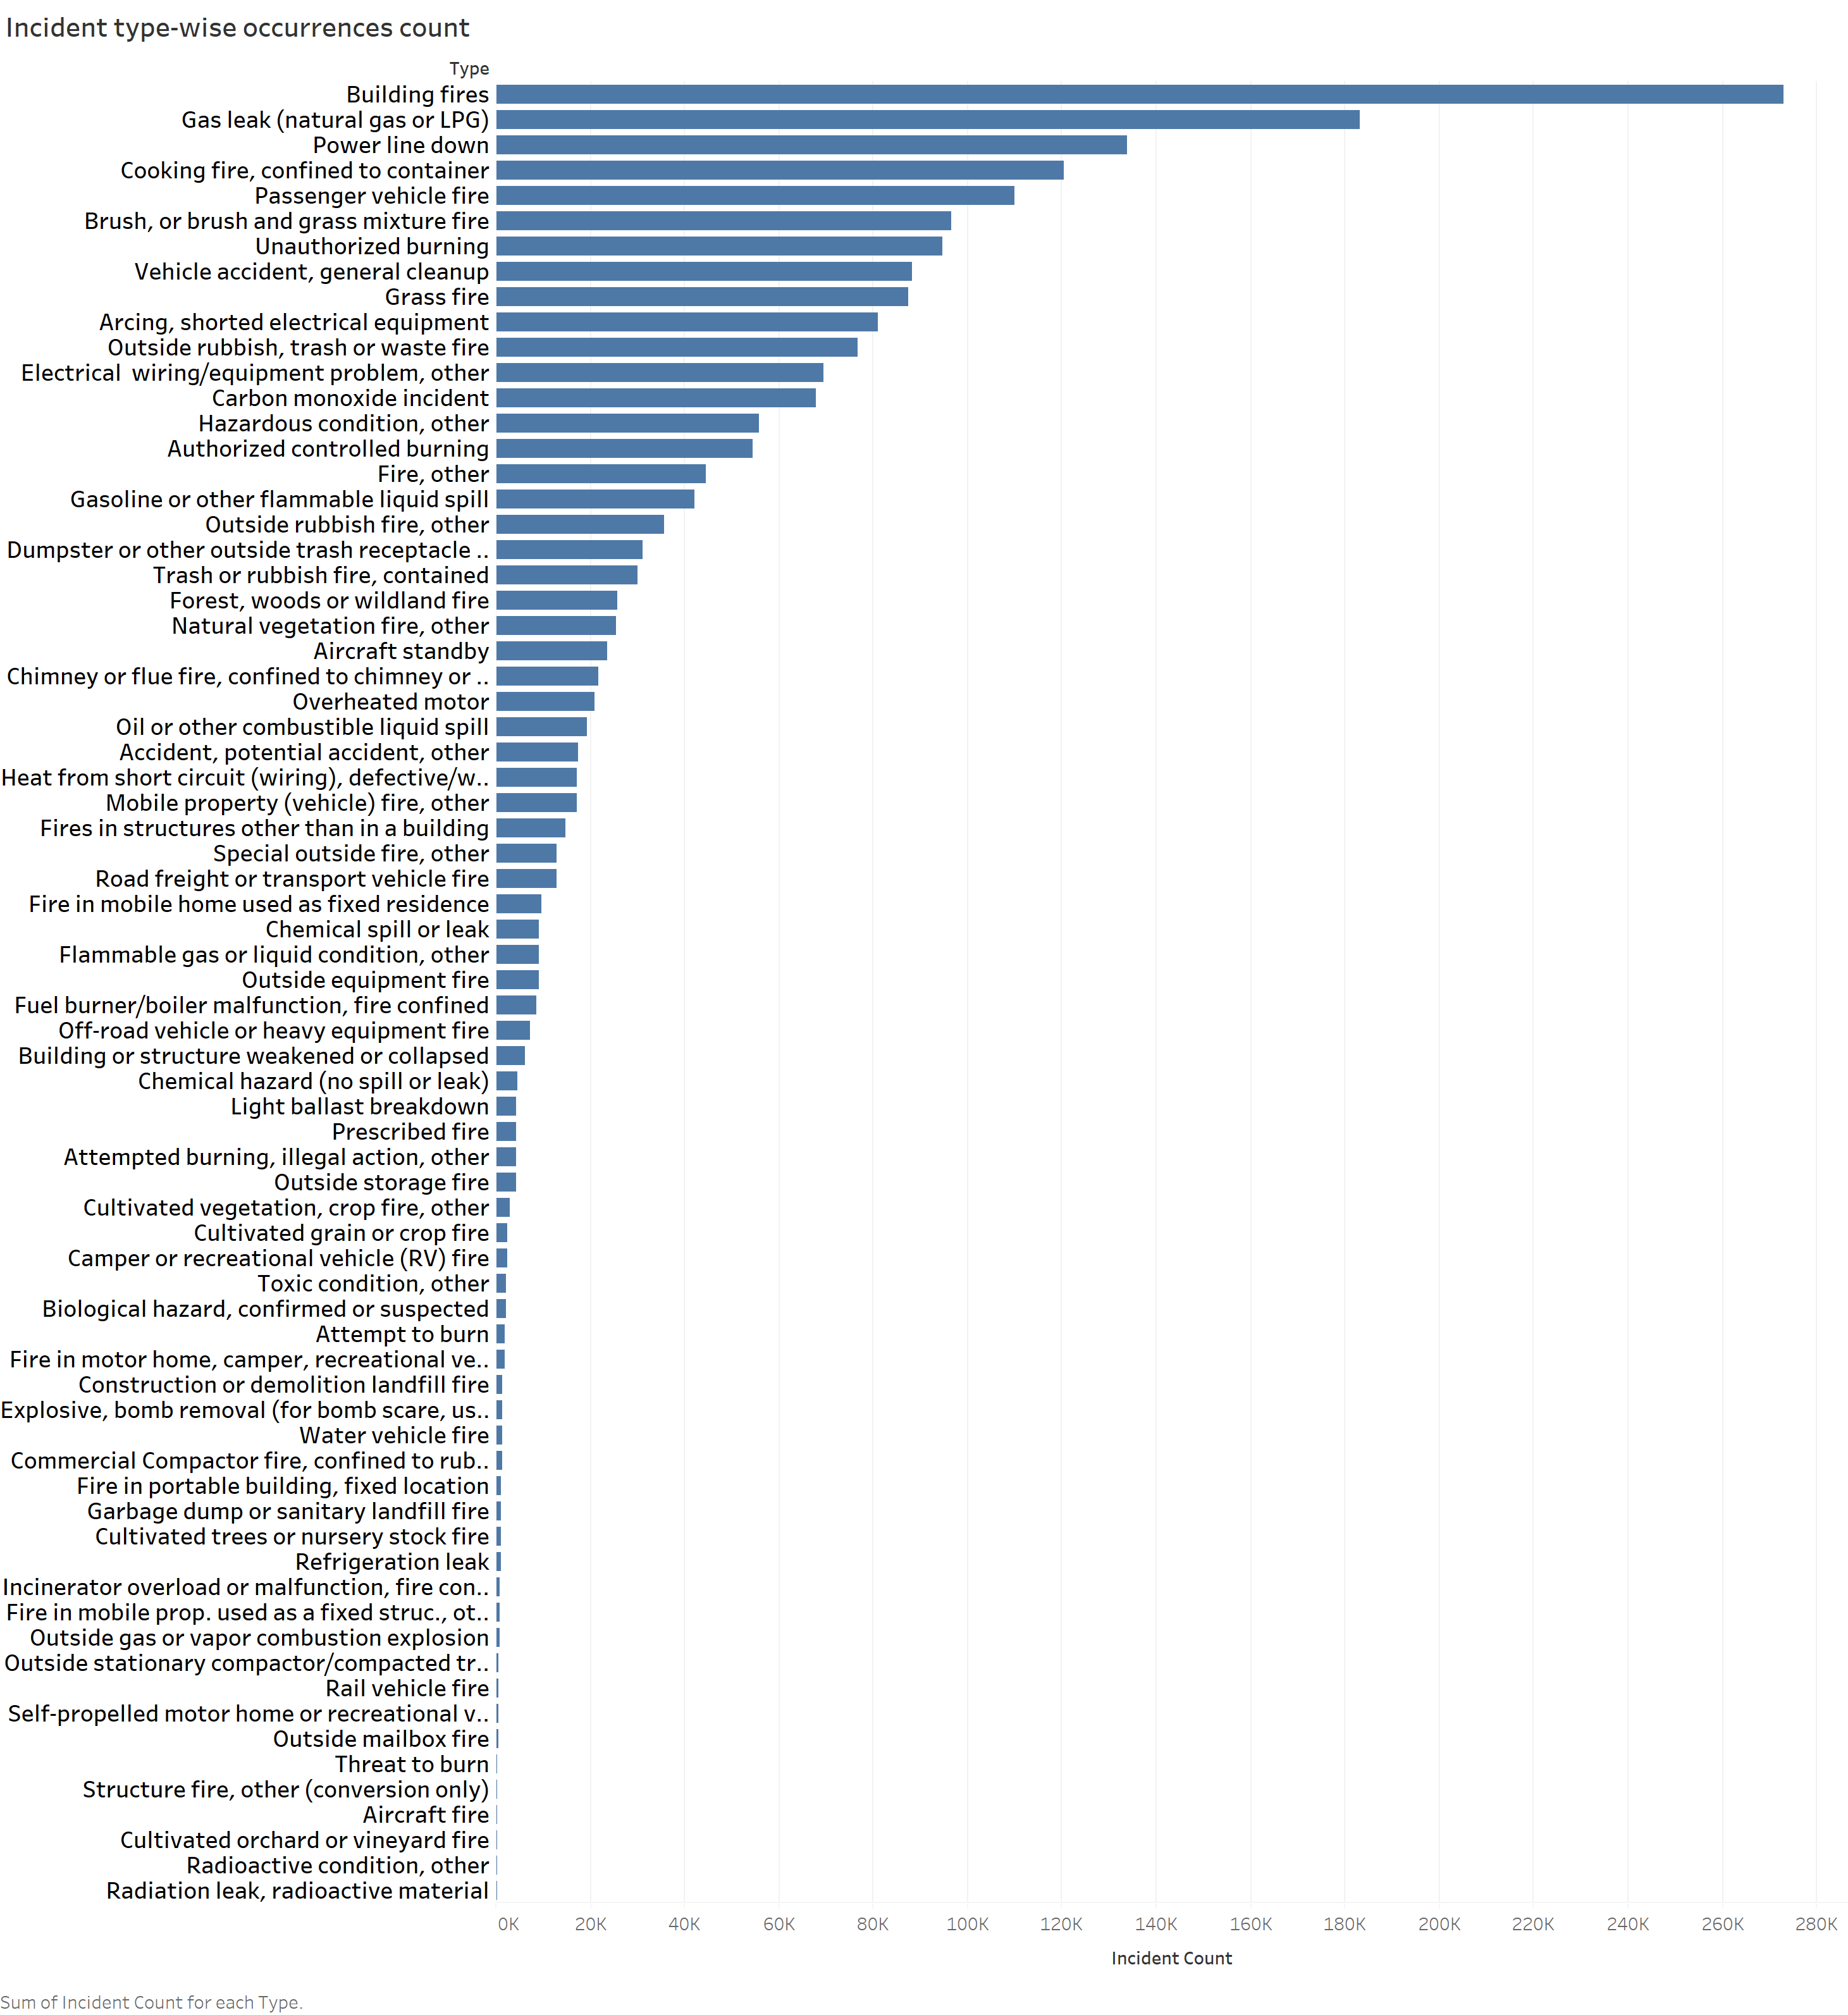

In [19]:
Image("Tableau_images/typewise_inc_count.png")

# Property Usage

In [20]:
prop_use_count = df_viz.groupby(['prop_use_definition']).size()
prop_use_count = pd.DataFrame({'incident_count':prop_use_count.values}, index = prop_use_count.index)
sorted_prop_use_count = prop_use_count.sort_values(by='incident_count', ascending = False).drop('PROPERTY USE')

In [21]:
writer = pd.ExcelWriter('sorted_prop_use_count.xlsx')
sorted_prop_use_count.to_excel(writer,'Sheet1')
writer.save()

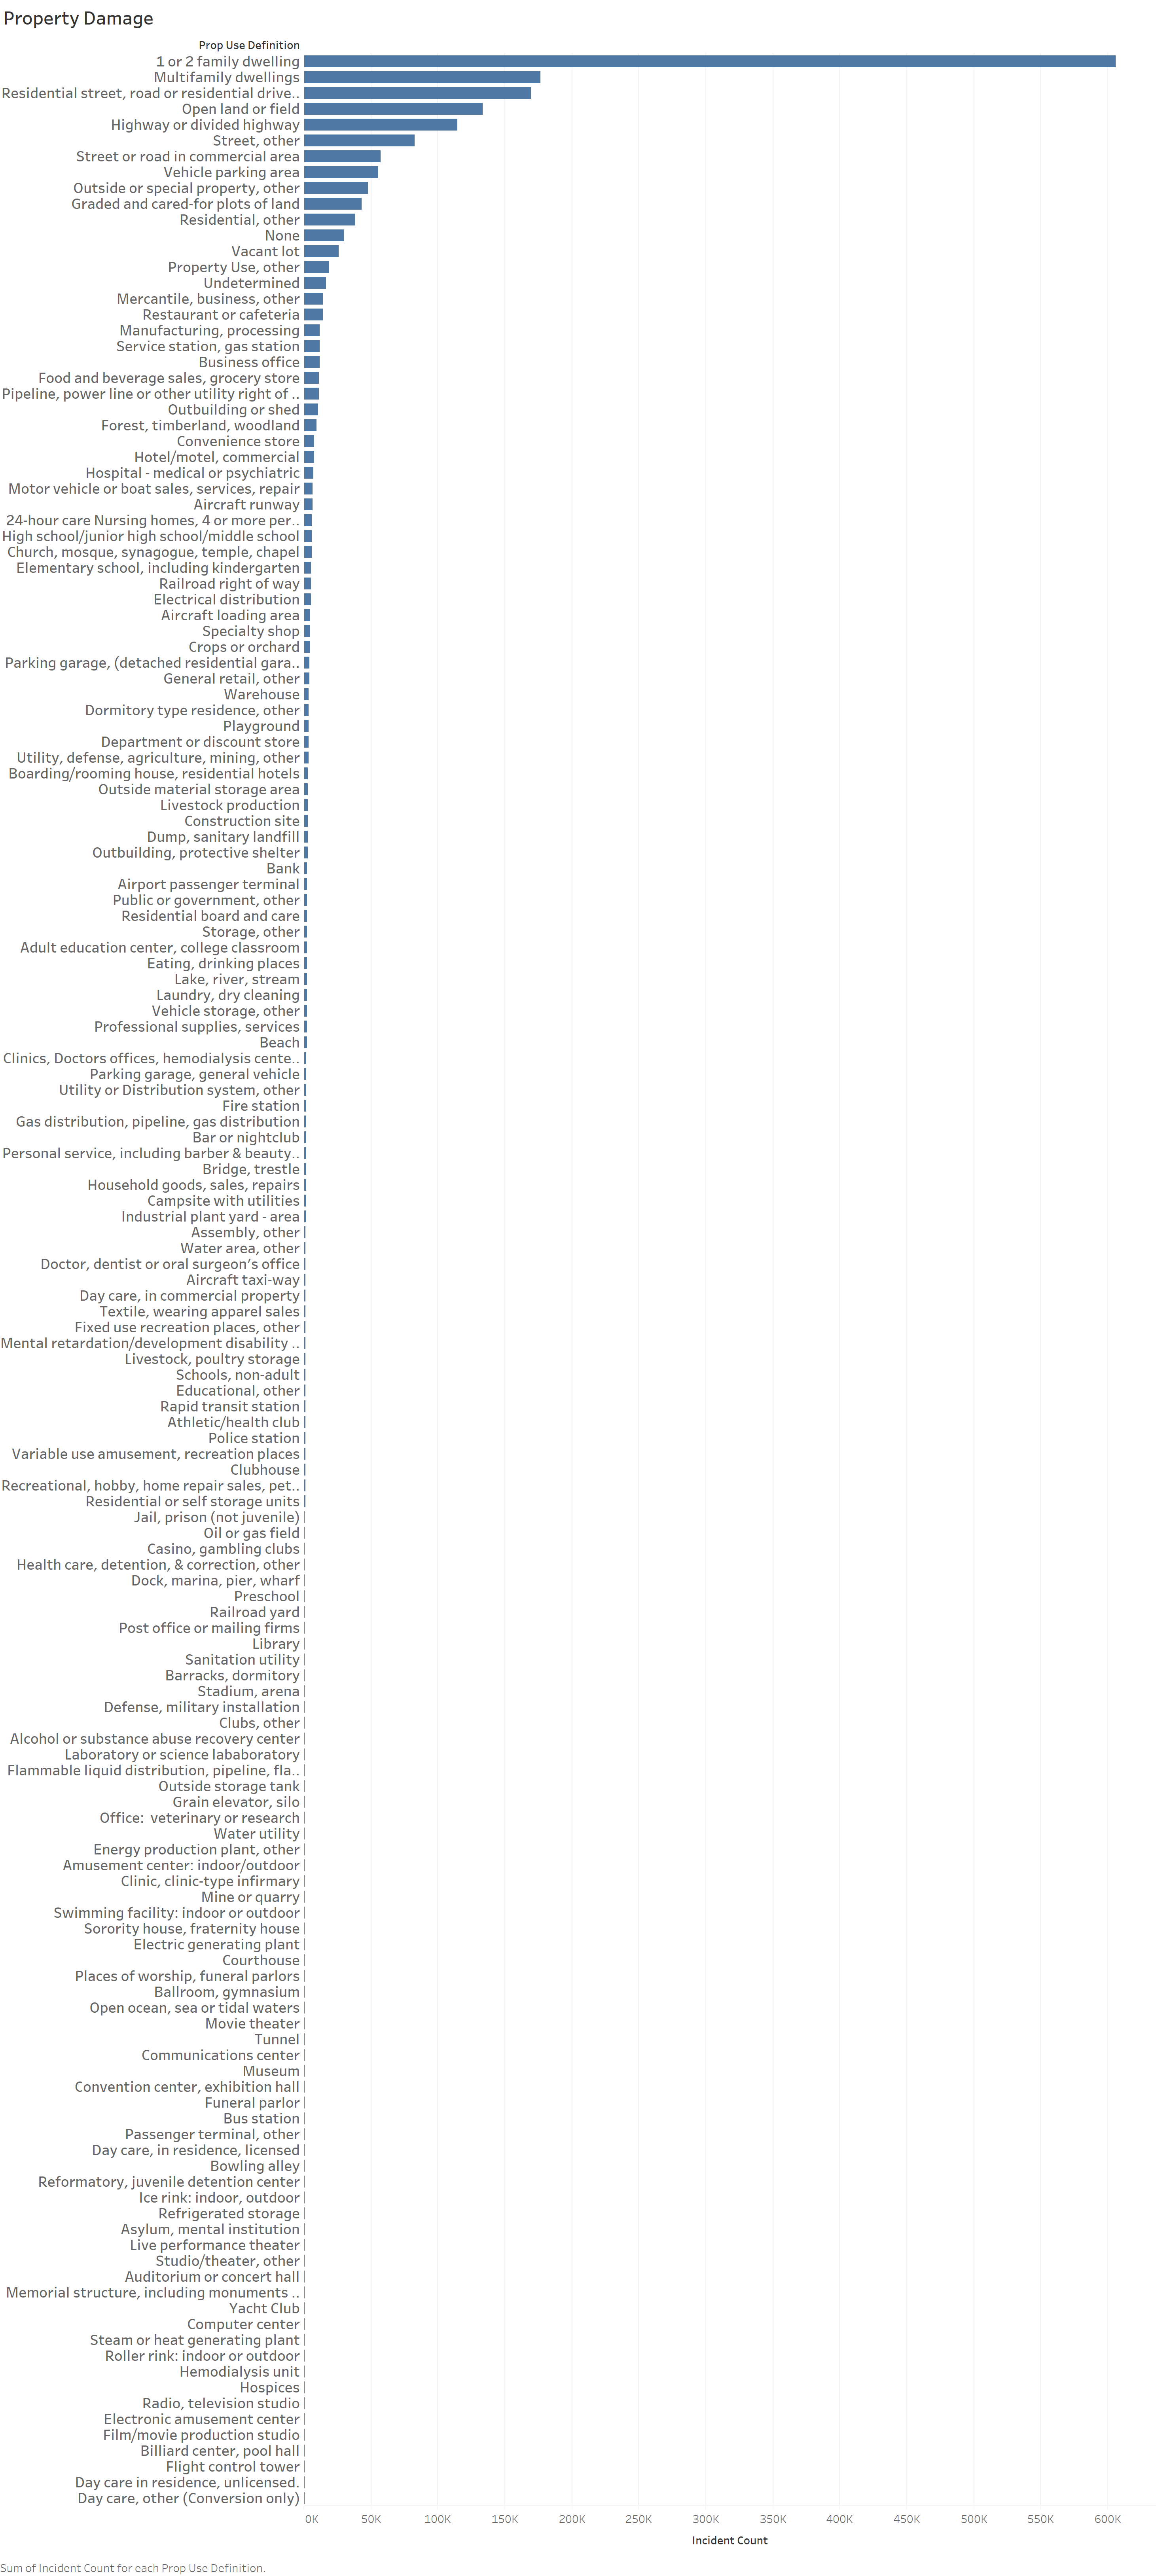

In [22]:
Image("Tableau_images/prop_use_count.png")

                                                  incident_count
prop_use_definition                                             
1 or 2 family dwelling                                    605719
Multifamily dwellings                                     176751
Residential street, road or residential driveway          169734
Open land or field                                        133216
Highway or divided highway                                114650


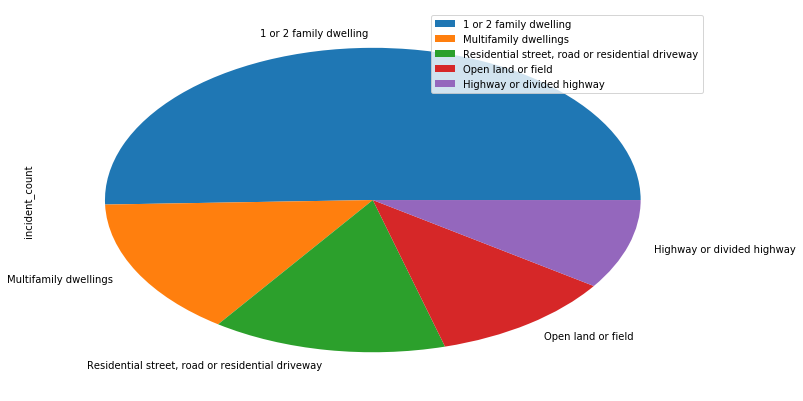

In [23]:
print(sorted_prop_use_count.head())
sorted_prop_use_count.head().plot.pie(y='incident_count', figsize=(12, 7))
plt.legend(loc="upper right")
plt.show()

# Feature Correlation

inc_date_unparsed    0.007630
exp_no              -0.000914
inc_type            -0.032583
add_wild             0.001373
aid                 -0.018151
alarm_unparsed       0.007630
arrival_unparsed     0.007608
lu_clear_unparsed    0.007616
app_mod             -0.035876
sup_app              0.008904
oth_app              0.011967
sup_per              0.070708
ems_per              1.000000
oth_per              0.014418
resou_aid            0.041658
ff_death             0.001302
ff_inj               0.015698
det_alert            0.081463
Name: ems_per, dtype: float64

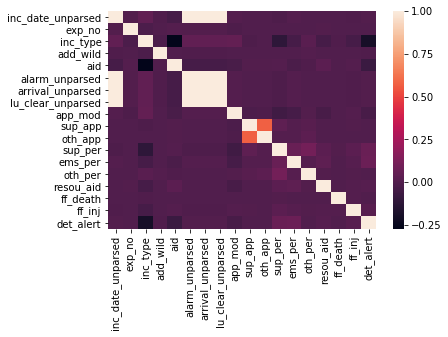

In [24]:
sns.heatmap(df.corr())
df.corr()['ems_per']

# Handling Imbalanced Data

Unbalanced dataset: 
 0    1977271
1     139357
Name: ems_per, dtype: int64 /n 0    0.934161
1    0.065839
Name: ems_per, dtype: float64


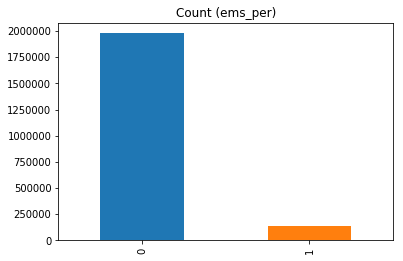

In [25]:
target_count = df['ems_per'].value_counts()
print('Unbalanced dataset:' ,'\n' , target_count, '/n', df['ems_per'].value_counts(normalize = True))

target_count.plot(kind='bar', title='Count (ems_per)');

Random under-sampling:
1    139357
0    139357
Name: ems_per, dtype: int64


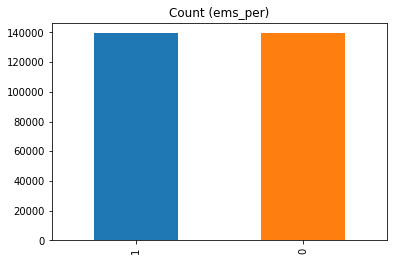

In [26]:
# Class count
count_class_0, count_class_1 = df.ems_per.value_counts()

# Divide by class
df_class_0 = df[df['ems_per'] == 0]
df_class_1 = df[df['ems_per'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.ems_per.value_counts())

df_test_under.ems_per.value_counts().plot(kind='bar', title='Count (ems_per)');

Random over-sampling:
1    1977271
0    1977271
Name: ems_per, dtype: int64


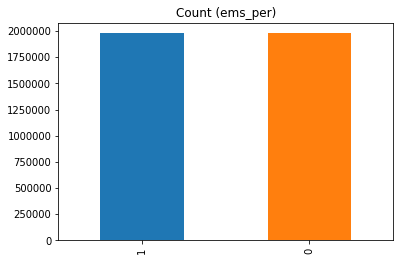

In [27]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.ems_per.value_counts())

df_test_over.ems_per.value_counts().plot(kind='bar', title='Count (ems_per)');

# Target Distribution for Predictors

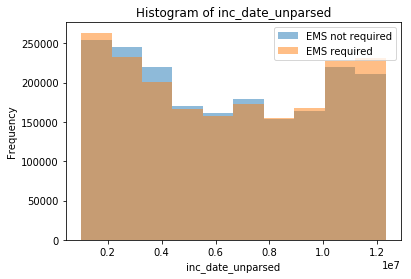

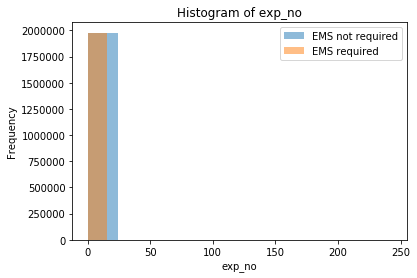

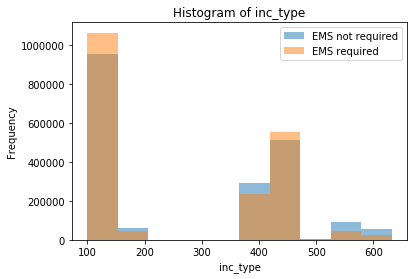

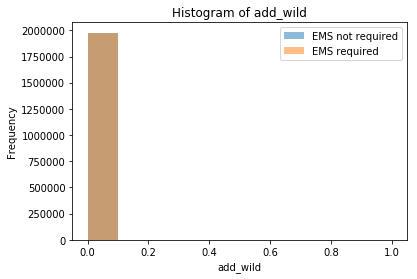

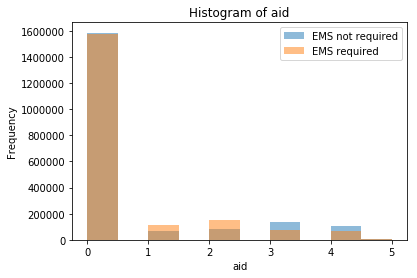

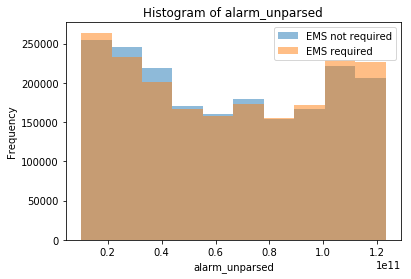

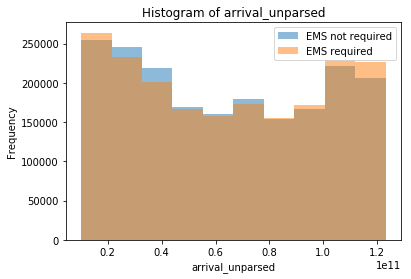

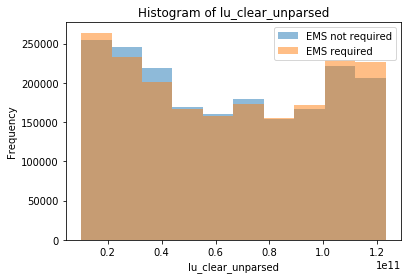

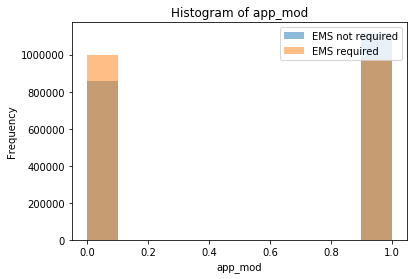

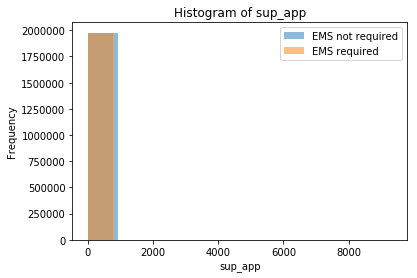

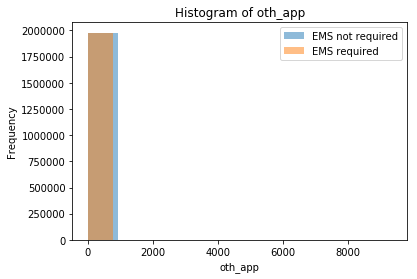

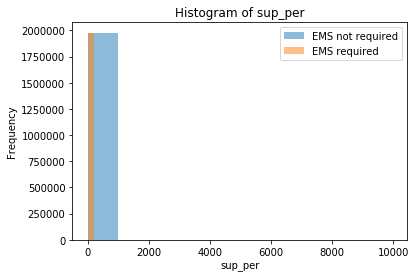

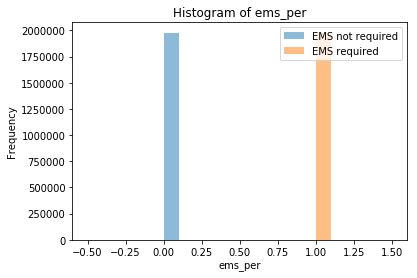

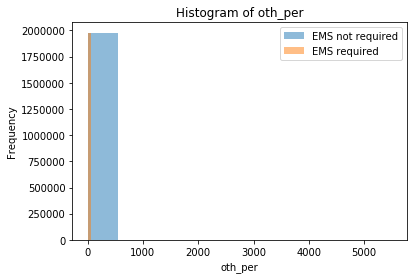

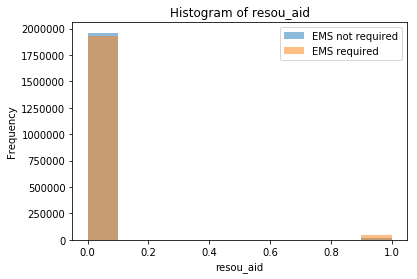

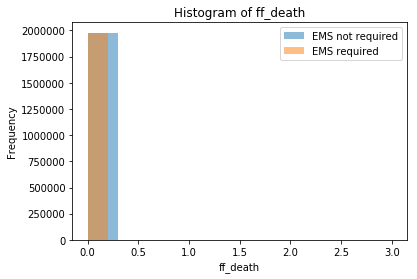

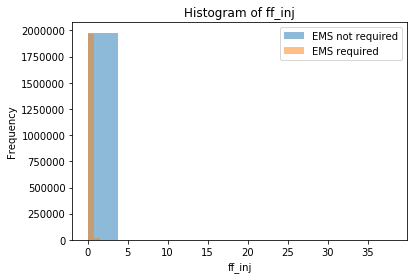

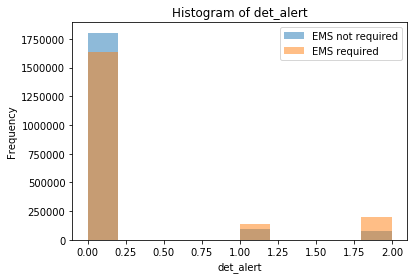

In [28]:
X = df_test_over

cols = list(X.columns.values)
for col in cols:
    plt.hist(X[X['ems_per']==0][col], 10, alpha = 0.5, label ='EMS not required')
    plt.hist(X[X['ems_per']==1][col], 10, alpha = 0.5, label ='EMS required')
    plt.legend(loc='upper right')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(col))
    plt.show()

In [29]:
X = df_test_over
y = X['ems_per']
X = X.drop('ems_per', axis = 1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression

In [33]:
logreg = LogisticRegression()
lr_fit = logreg.fit(X_train, y_train)
y_pred = lr_fit.predict(X_test)
logreg_score = lr_fit.predict_proba(X_test)[:,1]
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))
print('confusion matrix = ', confusion_matrix(y_test, y_pred))
print('accuracy score = ', accuracy_score(y_test, y_pred))
print('recall score = ', recall_score(y_test, y_pred))
print('precision score = ', precision_score(y_test, y_pred))
print('f1 score = ', f1_score(y_test, y_pred))
fpr_lr, tpr_lr, _ = roc_curve(y_test, logreg_score)
auc_lr = auc(fpr_lr, tpr_lr)

Accuracy of Logistic regression classifier on training set: 0.59
Accuracy of Logistic regression classifier on test set: 0.59
confusion matrix =  [[287462 108065]
 [219788 175594]]
accuracy score =  0.5854731707440426
recall score =  0.4441122762290646
precision score =  0.6190320067404878
f1 score =  0.5171823203606263


# Decision Tree

In [34]:
tree_clf = DecisionTreeClassifier()
tree_fit = tree_clf.fit(X_train, y_train)
y_pred = tree_fit.predict(X_test)
tree_score = tree_fit.predict_proba(X_test)[:,1]
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(tree_clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(tree_clf.score(X_test, y_test)))
print('confusion matrix = ', confusion_matrix(y_test, y_pred))
print('accuracy score = ', accuracy_score(y_test, y_pred))
print('recall score = ', recall_score(y_test, y_pred))
print('precision score = ', precision_score(y_test, y_pred))
print('f1 score = ', f1_score(y_test, y_pred))
fpr_tree, tpr_tree,  _ = roc_curve(y_test, tree_score)
auc_tree = auc(fpr_tree, tpr_tree)

Accuracy of Decision Tree classifier on training set: 0.97
Accuracy of Decision Tree classifier on test set: 0.94
confusion matrix =  [[357114  38413]
 [  7953 387429]]
accuracy score =  0.9413763151007258
recall score =  0.9798852755057135
precision score =  0.9097951822506939
f1 score =  0.9435403738809387


# Multinomial Naive Bayes

In [35]:
mnb = MultinomialNB()
mnb_fit = mnb.fit(X_train, y_train)
y_pred = mnb_fit.predict(X_test)
mnb_score = mnb_fit.predict_proba(X_test)[:,1]
print('Accuracy of mnb classifier on training set: {:.2f}'
     .format(mnb.score(X_train, y_train)))
print('Accuracy of mnb classifier on test set: {:.2f}'
     .format(mnb.score(X_test, y_test)))
print('confusion matrix = ', confusion_matrix(y_test, y_pred))
print('accuracy score = ', accuracy_score(y_test, y_pred))
print('recall score = ', recall_score(y_test, y_pred))
print('precision score = ', precision_score(y_test, y_pred))
print('f1 score = ', f1_score(y_test, y_pred))
fpr_mnb, tpr_mnb,  _ = roc_curve(y_test, mnb_score)
auc_mnb = auc(fpr_mnb, tpr_mnb)

Accuracy of mnb classifier on training set: 0.56
Accuracy of mnb classifier on test set: 0.56
confusion matrix =  [[307765  87762]
 [263314 132068]]
accuracy score =  0.5561107535759486
recall score =  0.334026334026334
precision score =  0.6007733248419233
f1 score =  0.42934143027119104


# AUC Curves

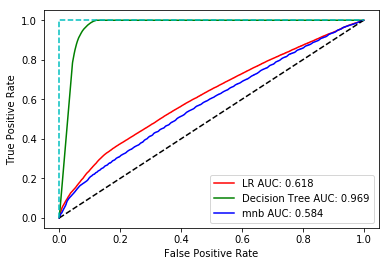

In [36]:
plt.plot(fpr_lr, tpr_lr,'r-',label = 'LR AUC: %.3f'%auc_lr)
plt.plot(fpr_tree, tpr_tree,'g-',label = 'Decision Tree AUC: %.3f'%auc_tree)
plt.plot(fpr_mnb, tpr_mnb,'b-',label = 'mnb AUC: %.3f'%auc_mnb)
plt.plot([0,1],[0,1],'k--')
plt.plot([0,0,1,1],[0,1,1,1],'c--')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Cross Validation for Decision Tree

In [37]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
print (cross_val_score(tree_clf, X, y, cv=k_fold, n_jobs=1))

[0.94850994 0.9481888  0.94835809 0.94835809 0.94845165 0.94820889
 0.94911418 0.9487374  0.94887901 0.94851993]


# Feature Importance

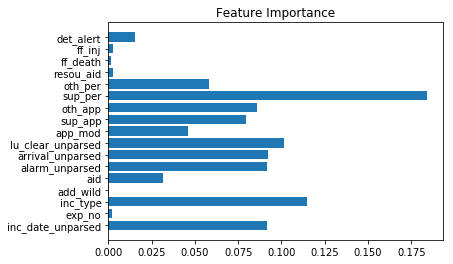

In [38]:
plt.figure()
plt.title('Feature Importance')
plt.barh(range(X_train.shape[1]), tree_clf.feature_importances_)
plt.yticks(range(X_train.shape[1]), list(X.columns.values))
plt.show()